Мне ещё кое-что нужно - аннотация позиций генов.

Задачу нужно делать по выравниванию и для каждой последовательности индивидуально. Мне не важна позиция каждого нуклеотида в последовательности, важна позиция в кодоне. 
В итоге, для каждой веточки пробегается по кодонам, которые были изменены (нужна фиктивная колонка с индексами, чтобы легко выделять позицию в кодоне), собираем информацию о том, что это за мутация (0,1,2 это все, син и фф соотв., так будет легко фильтровать),пишем все в табличку. Отдельно нужно сохранять частоты триплетов и нуклеотидов для каждой родительской ноды.

In [29]:
import re
from queue import Queue
from typing import Iterable
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ete3
from ete3 import PhyloTree
from scipy.stats import entropy
from scipy import spatial

from Bio.Data import CodonTable

import warnings
warnings.filterwarnings("ignore")

In [2]:
path_to_tree = "../data/interim/iqtree_runs/drun1/anc.treefile"
path_to_states = "../data/interim/iqtree_runs/drun1/anc.state"
path_to_leaves = "../data/interim/leaves_nematoda_states_parted.tsv"

In [3]:
tree = tree = PhyloTree(path_to_tree, format=1)

In [4]:
tree.describe()

Number of leaf nodes:	144
Total number of nodes:	286
Rooted:	No
Most distant node:	Meloidogyne_javanica
Max. distance:	5.446504


In [5]:
# print(tree.get_ascii())
# tree.show()

In [6]:
anc = pd.read_csv(path_to_states, sep="\t", comment='#',)
leaves = pd.read_csv(path_to_leaves, sep="\t")

states = pd.concat([anc, leaves]).sort_values(["Node", "Part", "Site"])
print(states.shape)
states.head()

(2866578, 8)


,Node,Part,Site,State,p_A,p_C,p_G,p_T
6516,Acanthocheilonema_viteae,1,1,A,1.0,0.0,0.0,0.0
6517,Acanthocheilonema_viteae,1,2,T,0.0,0.0,0.0,1.0
6518,Acanthocheilonema_viteae,1,3,T,0.0,0.0,0.0,1.0
6519,Acanthocheilonema_viteae,1,4,T,0.0,0.0,0.0,1.0
6520,Acanthocheilonema_viteae,1,5,T,0.0,0.0,0.0,1.0


In [7]:
anc[anc.Node == "Node6"]

,Node,Part,Site,State,p_A,p_C,p_G,p_T
0,Node6,1,1,T,0.03012,0.00375,0.00625,0.95988
1,Node6,1,2,T,0.00001,0.00006,0.00000,0.99993
2,Node6,1,3,G,0.30508,0.02994,0.53229,0.13270
3,Node6,1,4,T,0.00953,0.30213,0.02986,0.65848
4,Node6,1,5,A,0.54912,0.00212,0.40747,0.04130
...,...,...,...,...,...,...,...,...
10018,Node6,5,2936,T,0.00041,0.00338,0.00014,0.99606
10019,Node6,5,2937,T,0.11066,0.06397,0.06969,0.75568
10020,Node6,5,2938,T,0.09209,0.06654,0.06031,0.78106
10021,Node6,5,2939,T,0.00006,0.00063,0.00002,0.99929


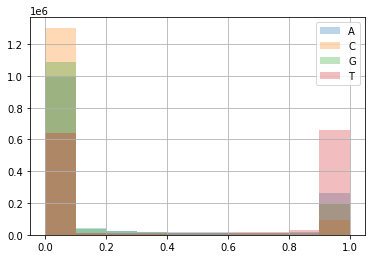

In [8]:
anc.p_A.hist(alpha=.3, label="A")
anc.p_C.hist(alpha=.3, label="C")
anc.p_G.hist(alpha=.3, label="G")
anc.p_T.hist(alpha=.3, label="T")
plt.legend()

## 10% of positions are uncertain

In [9]:
np.any(anc[["p_A", "p_C", "p_G", "p_T"]] > 0.8, 1).value_counts(normalize=True)

True     0.894154
False    0.105846
dtype: float64

In [10]:
mentr = entropy(anc[["p_A", "p_C", "p_G", "p_T"]], axis=1)

Text(0.5, 1.0, 'Entropy')

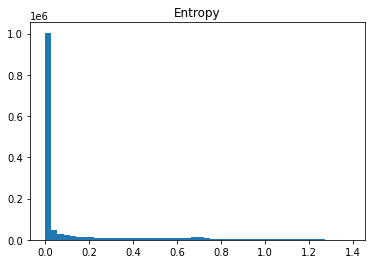

In [11]:
plt.hist(mentr, bins=50)
plt.title("Entropy")

<AxesSubplot:>

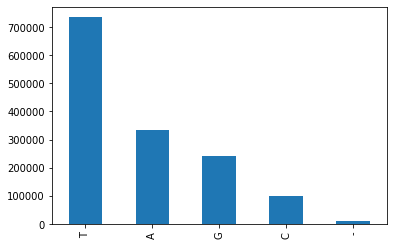

In [12]:
anc.State.value_counts().plot.bar()

## MUTSPEC

In [13]:
mutations = pd.read_csv("../data/processed/nematoda_mutations.csv")
edge_mutspec_all = pd.read_csv("../data/processed/nematoda_mutspec_all.csv")
edge_mutspec_syn = pd.read_csv("../data/processed/nematoda_mutspec_syn.csv")
edge_mutspec_ff = pd.read_csv("../data/processed/nematoda_mutspec_ff.csv")

### Translate mutations to heavy strand

(Genes are on Heavy strand, but sequenced Light strand equivalent - mRNA)

In [14]:
translator = str.maketrans("ACGT", "TGCA")


def rev_comp(mut: str):
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [15]:
edge_mutspec_all["Mut"] = edge_mutspec_all["Mut"].str.translate(translator)
edge_mutspec_syn["Mut"] = edge_mutspec_syn["Mut"].str.translate(translator)
edge_mutspec_ff["Mut"] = edge_mutspec_ff["Mut"].str.translate(translator)

### Plot mutations and MutSpec

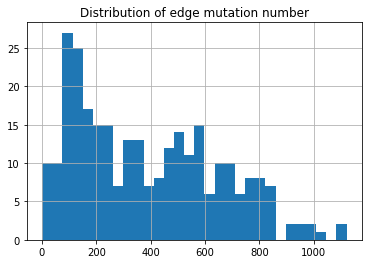

In [16]:
mutations.groupby("AltNode").apply(len).hist(bins=30)
plt.title("Distribution of edge mutation number");

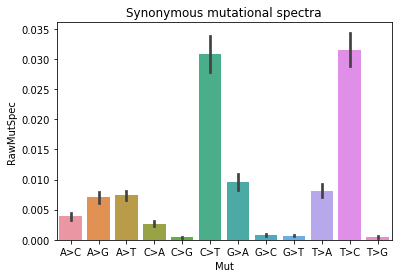

In [17]:
sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec_syn, order=sorted(edge_mutspec_syn.Mut.unique()));
plt.title("Synonymous mutational spectra")
plt.savefig("../figures/nematoda_mutspec_syn.svg")
plt.show()

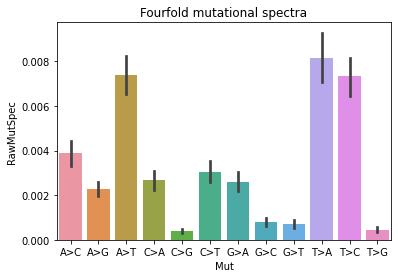

In [18]:
sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec_ff, order=sorted(edge_mutspec_ff.Mut.unique()));
plt.title("Fourfold mutational spectra")
plt.savefig("../figures/nematoda_mutspec_ff.svg")
plt.show()

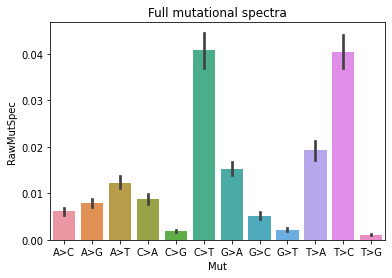

In [20]:
sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec_all, order=sorted(edge_mutspec_all.Mut.unique()));
plt.title("Full mutational spectra")
plt.savefig("../figures/nematoda_mutspec_all.svg")
plt.show()

### Prepare edge data for tree vizualisation

In [14]:
def prepare_one_mut_share_file(mutspec: pd.DataFrame, filename: str, sbs="C>T"):
    assert bool(re.match("[ACGT]>[ACGT]", sbs)), "sbs is not appropriate"
    cols = ["RefNode", "AltNode", "MutSpec"]
    for c in cols:
        assert c in mutspec, f"Column {c} is not in mutspec dataframe"
    
    shares = mutspec[mutspec.Mut == sbs][cols]
    shares.to_csv(filename, "\t", index=None)
    return shares


In [27]:
pref_sbs = "C>T"
prepare_one_mut_share_file(edge_mutspec, "../data/processed/c2t_edge_mutspec.tsv")

<AxesSubplot:>

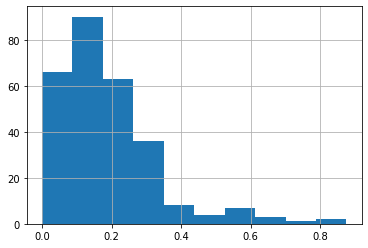

In [23]:
edge_mutspec_ff[edge_mutspec_ff.Mut == "A>G"]["MutSpec"].hist()

### Grouping nodes on tree for everage mutspec

In [21]:
path_to_groups = "../data/interim/nematoda_groups.txt"

_collect_names = False
groups = defaultdict(list)
with open(path_to_groups) as fin:
    for line in fin:
        if line.endswith(")\n"):
            gr_num = int(line.strip(")\n"))
            _collect_names = True
        else:
            if len(line.strip()) == 0:
                _collect_names = False

            if _collect_names:
                name = line.strip().replace(" ", "_")
                groups[gr_num].append(name)


In [22]:
possible_sbs12 = sorted(edge_mutspec_all.Mut.unique())

In [23]:
all_nodes = set(edge_mutspec_all.AltNode)

for gr_num, gr in groups.items():
    for name in gr:
        if name not in all_nodes:
            print(gr_num, name)
print("All nodes found!")

All nodes found!


In [32]:
def get_joined_mutspec(edge_mutspec, groups, sim_cutoff=0.8):
    """ Join mutspec of edges by groups"""
    # gr_mutspec = dict()
    gr_mutspec = []
    for gr_num, gr in groups.items():
        pruned_tree = tree.copy()
        pruned_tree.prune(gr)
        assert len(pruned_tree) == len(gr)

        full_gr = [x.name for x in pruned_tree.iter_descendants()]
        gr_ms = edge_mutspec[edge_mutspec["AltNode"].isin(full_gr)]

        separated_ms = []
        for node in full_gr:
            sms = gr_ms[gr_ms["AltNode"] == node].sort_values("Mut")["MutSpec"].values
            separated_ms.append(sms)
        
        to_drop = []
        for sms1, node1 in zip(separated_ms, full_gr):
            one_sims = []
            for sms2, node2 in zip(separated_ms, full_gr):
                if node1 == node2:
                    continue
                sim = 1 - spatial.distance.cosine(sms1, sms2)
                one_sims.append(sim)
            
            if np.mean(one_sims) < sim_cutoff:
                print(f"Drop node {node1} from group {gr_num} with average similarity to other nodes {np.mean(one_sims):.2f}")
                to_drop.append(node1)

        full_gr = set(full_gr).difference(to_drop)
        gr_ms = edge_mutspec[edge_mutspec["AltNode"].isin(full_gr)]
        gr_ms["Group"] = gr_num
        gr_mutspec.append(gr_ms)

        # gr_ms_joined = gr_ms.groupby("Mut")[["ObsFr", "Divisor"]].sum().reset_index()
        # gr_ms_joined["RawMutSpec"] = gr_ms_joined.ObsFr / gr_ms_joined.Divisor
        # gr_ms_joined["MutSpec"] = gr_ms_joined["RawMutSpec"] / gr_ms_joined["RawMutSpec"].sum()
        # gr_mutspec[gr_num] = gr_ms_joined
    
    gr_mutspec_df = pd.concat(gr_mutspec)
    return gr_mutspec_df


In [33]:
gr_mutspec_all = get_joined_mutspec(edge_mutspec_all, groups)

Drop node Node101 from group 2 with average similarity to other nodes 0.79
Drop node Node70 from group 4 with average similarity to other nodes 0.79
Drop node Node124 from group 5 with average similarity to other nodes 0.78
Drop node Node125 from group 5 with average similarity to other nodes 0.71
Drop node Contracaecum_ogmorhini_sensu_lato_Australia from group 6 with average similarity to other nodes 0.74
Drop node Anisakis_pegreffii from group 6 with average similarity to other nodes 0.71
Drop node Node58 from group 7 with average similarity to other nodes 0.73
Drop node Node59 from group 7 with average similarity to other nodes 0.69
Drop node Node64 from group 7 with average similarity to other nodes 0.78
Drop node Node61 from group 7 with average similarity to other nodes 0.79
Drop node Node62 from group 7 with average similarity to other nodes 0.79
Drop node Ascaris_suum from group 7 with average similarity to other nodes 0.79
Drop node Parascaris_equorum from group 7 with average

In [34]:
gr_mutspec_syn = get_joined_mutspec(edge_mutspec_syn, groups)

Drop node Node101 from group 2 with average similarity to other nodes 0.72
Drop node Hypodontus_macropi from group 2 with average similarity to other nodes 0.80
Drop node Node115 from group 3 with average similarity to other nodes 0.75
Drop node Node70 from group 4 with average similarity to other nodes 0.77
Drop node Metastrongylus_pudendotectus from group 4 with average similarity to other nodes 0.79
Drop node Node124 from group 5 with average similarity to other nodes 0.68
Drop node Node125 from group 5 with average similarity to other nodes 0.70
Drop node Node129 from group 5 with average similarity to other nodes 0.77
Drop node Node133 from group 5 with average similarity to other nodes 0.80
Drop node Contracaecum_ogmorhini_sensu_lato_Australia from group 6 with average similarity to other nodes 0.78
Drop node Anisakis_pegreffii from group 6 with average similarity to other nodes 0.75
Drop node Node58 from group 7 with average similarity to other nodes 0.67
Drop node Node59 from g

In [35]:
gr_mutspec_ff = get_joined_mutspec(edge_mutspec_ff, groups)

Drop node Node85 from group 1 with average similarity to other nodes 0.71
Drop node Node86 from group 1 with average similarity to other nodes 0.69
Drop node Node95 from group 1 with average similarity to other nodes 0.79
Drop node Node88 from group 1 with average similarity to other nodes 0.78
Drop node Cyathostomum_catinatum from group 1 with average similarity to other nodes 0.69
Drop node Cyathostomum_pateratum from group 1 with average similarity to other nodes 0.67
Drop node Cylicocyclus_radiatus from group 1 with average similarity to other nodes 0.75
Drop node Cylicocyclus_ashworthi from group 1 with average similarity to other nodes 0.76
Drop node Node113 from group 3 with average similarity to other nodes 0.76
Drop node Node114 from group 3 with average similarity to other nodes 0.76
Drop node Nematodirus_oiratianus from group 3 with average similarity to other nodes 0.76
Drop node Node115 from group 3 with average similarity to other nodes 0.66
Drop node Node70 from group 4 

In [ ]:
mean_mutspec_all = edge_mutspec_all.groupby("Mut").MutSpec.mean().sort_index()
print("All")
print("Group\tSimilarity to mean tree MutSpec")
for gr_num in gr_mutspec_all:
    ms = gr_mutspec_all[gr_num].sort_values("Mut").MutSpec
    if len(ms) == 12:
        sim = 1 - spatial.distance.cosine(ms, mean_mutspec_all)
        print(f"{gr_num}\t{sim:.2f}")

In [ ]:
mean_mutspec_syn = edge_mutspec_syn.groupby("Mut").MutSpec.mean().sort_index()
print("Syn")
print("Group\tSimilarity to mean tree MutSpec")
for gr_num in gr_mutspec_syn:
    ms = gr_mutspec_syn[gr_num].sort_values("Mut").MutSpec
    if len(ms) == 12:
        sim = 1 - spatial.distance.cosine(ms, mean_mutspec_syn)
        print(f"{gr_num}\t{sim:.2f}")

In [ ]:
mean_mutspec_ff = edge_mutspec_ff.groupby("Mut").MutSpec.mean().sort_index()
print("Fourfold")
print("Group\tSimilarity to mean tree MutSpec")
for gr_num in gr_mutspec_ff:
    ms = gr_mutspec_ff[gr_num].sort_values("Mut").MutSpec
    if len(ms) == 12:
        sim = 1 - spatial.distance.cosine(ms, mean_mutspec_ff)
        print(f"{gr_num}\t{sim:.2f}")

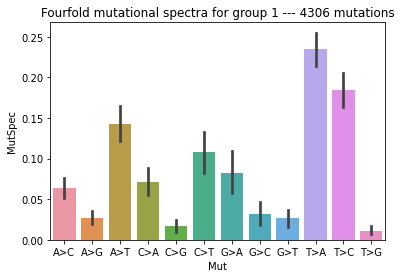

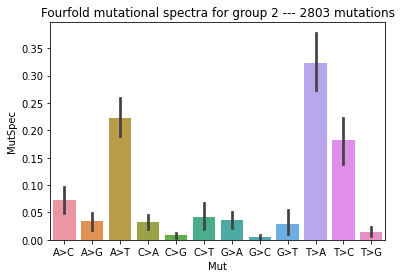

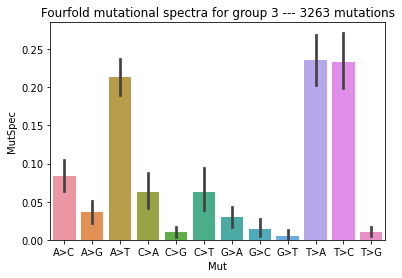

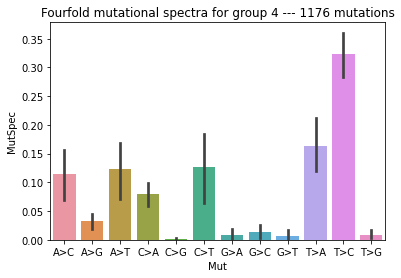

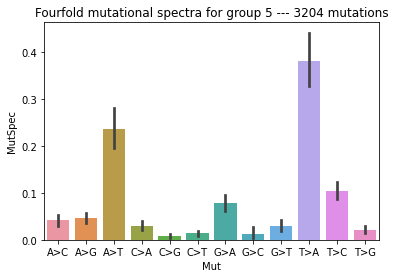

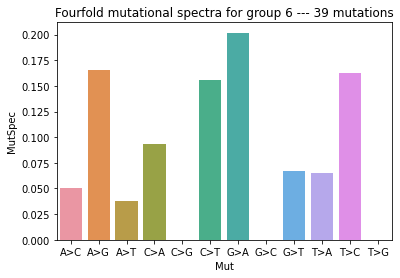

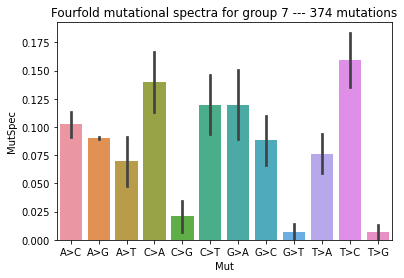

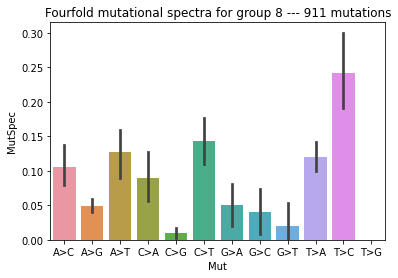

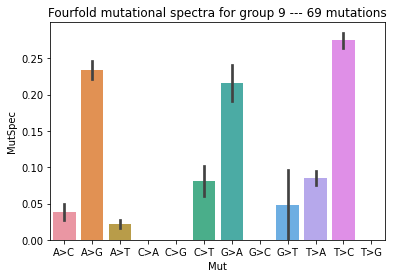

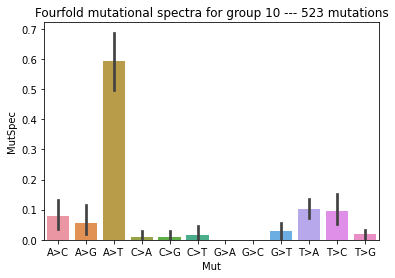

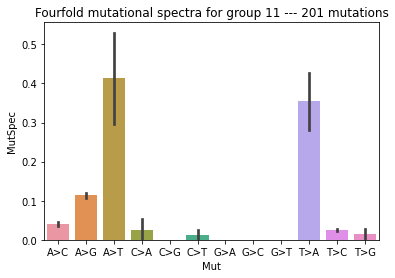

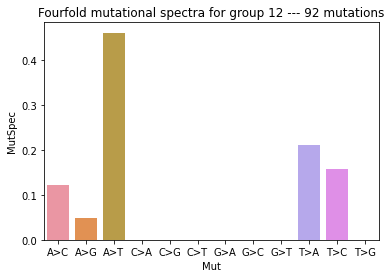

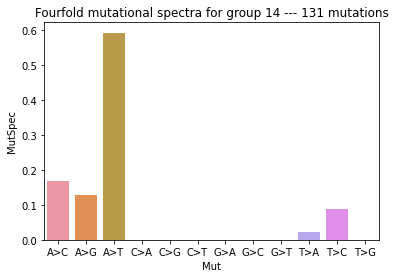

In [53]:
for gr_num in gr_mutspec_ff.Group.unique():
    ms = gr_mutspec_ff[gr_mutspec_ff.Group == gr_num]
    mut_num = ms.ObsFr.sum()
    sns.barplot(x="Mut", y="MutSpec", data=ms, order=possible_sbs12)
    plt.title(f"Fourfold mutational spectra for group {gr_num} --- {mut_num} mutations")
    plt.show()